# Homework 5 – Analysis of distributed data sources

In the dataset we already used in the exercise, there is another target attribute: `age`. Apply your learnings on this new target and assess the performance of each classifier.

1. Build and test a text classifier targeting the age of a user according their age classes (0-10, 11-20, 21-30, 31+).

2. Build a ML name classifier that classifies the age of a user according their age classes (0-10, 11-20, 21-30, 31+).

3. Build a meta classifier that combines the previously built classifiers based on their age classes (0-10, 11-20, 21-30, 31+).

As introduced in a previous homework, please save each classifier with the following command: `dump(tree_clf, 'clf1.joblib')`.<br/> Name them `clf1.joblib`, `clf2.joblib` and `clf3.joblib`. 


**Please make sure:**

- Each cell (essential step) is commented on with a short sentence
- New variables / fields are output in sufficient length (e.g., `df.head(10)`)
- Each of the tasks is answered with a short written statement
- Tidy up your code

There are no defined functions, we expect you to structure your code on your own (functions are not mandatory). Don't forget to upload the joblibs next to your notebook! 

<hr/>

## Coding Area

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB as bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier 
from joblib import dump
import unidecode
import re
import nltk
from nltk.corpus import stopwords

In [2]:
data = pd.read_pickle('data/twitterData.pkl')
data.shape

(2916, 6)

In [3]:
# get age class by floor div e. g. 31 // 10 = 3
data['age_class'] = data['age'].floordiv(10)
# corner case for everyone >= 31
data[data['age_class']>3] = 3
data.head(20)

,screen_name,name,tweets_concatenated,avatar_url,gender,age,age_class
0,DatZerooo,David,Warum riecht mein Bruder nach Pizza wenn er ei...,http://pbs.twimg.com/profile_images/7569661512...,M,16.0,1.0
0,reap705,Oliver Gast,[CSS] Ein Off-canvas-Menü mit Dropdown-Navigat...,http://pbs.twimg.com/profile_images/1366984169...,M,15.0,1.0
0,Dossary1995,Khalid Aldossary,,http://pbs.twimg.com/profile_images/4167523242...,M,37.0,3.0
0,3,3,3,3,3,3.0,3.0
0,Narutofreak935,Avengar,@GrandlineTV gib nicht auf und mach dein Ding ...,http://pbs.twimg.com/profile_images/7317971734...,F,19.0,1.0
0,miley_sarah,Sarah,"RT @bomelino: Das ""Backe, backe Kuchen""-Lied i...",http://pbs.twimg.com/profile_images/7584397626...,M,18.0,1.0
0,DerIncubus,Der Incubus,@NicoleAllm Na ... gut ins neue Jahr gestartet...,http://pbs.twimg.com/profile_images/5808649200...,F,22.0,2.0
0,Petouser,ペトユサ (Petoyusa),Verschwörungstheorie: Pokemon Go wird von der ...,http://pbs.twimg.com/profile_images/6626943925...,M,26.0,2.0
0,ChrisWhite126,Chris White,Ach du scheiße ist das warm. :( Hab locker 5kg...,http://pbs.twimg.com/profile_images/6463341220...,M,37.0,3.0
0,MusicFreakFever,Nadine (:,Heute nur DREI (!) Schulstunden !\n Ich LIIIIE...,http://pbs.twimg.com/profile_images/3788000003...,M,15.0,1.0


In [4]:
data['age'].isna().sum()

1607

In [5]:
data = data[data['age_class'].notna()]
data.shape

(1309, 7)

<AxesSubplot:>

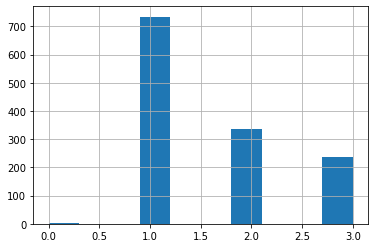

In [6]:

data['age_class'].hist()

In [7]:
# adapted from here https://stackoverflow.com/a/58356570/5755604
def remove_emojis(dirty_str):
    if pd.isnull(dirty_str):
        return ""

    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)
    return re.sub(emoj, '', str(dirty_str))

In [8]:
def sanitize_str(dirty_str):

    # check for none
    if pd.isnull(dirty_str):
        return ""

    # remove punctation
    punctuation = r"""\"$%&?!'()*+,-./:;<=>[\]^__`{|}~0123456789#@"""
    san_str = dirty_str.translate(str.maketrans('', '', punctuation))

    # ersetze Umlaute, Akzente etc. durch Ascii-Entsprechung
    san_str = unidecode.unidecode(san_str)

    # delete multiple spaces
    san_str = " ".join(san_str.split())


    # replace empty string with ""
    if not san_str:
        return ""
    else:
        
        return san_str.lower()

In [9]:
data.name = data.name.apply(remove_emojis)
data.tweets_concatenated = data.tweets_concatenated.apply(remove_emojis)
data.name = data.name.apply(sanitize_str)
data.tweets_concatenated = data.tweets_concatenated.apply(sanitize_str)

data = data[data['tweets_concatenated'] != '']
data.head(10)

,screen_name,name,tweets_concatenated,avatar_url,gender,age,age_class
0,DatZerooo,david,warum riecht mein bruder nach pizza wenn er ei...,http://pbs.twimg.com/profile_images/7569661512...,M,16.0,1.0
0,reap705,oliver gast,css ein offcanvasmenu mit dropdownnavigation p...,http://pbs.twimg.com/profile_images/1366984169...,M,15.0,1.0
0,Narutofreak935,avengar,grandlinetv gib nicht auf und mach dein ding w...,http://pbs.twimg.com/profile_images/7317971734...,F,19.0,1.0
0,miley_sarah,sarah,rt bomelino das backe backe kuchenlied ist ein...,http://pbs.twimg.com/profile_images/7584397626...,M,18.0,1.0
0,DerIncubus,der incubus,nicoleallm na gut ins neue jahr gestartetrt ow...,http://pbs.twimg.com/profile_images/5808649200...,F,22.0,2.0
0,Petouser,petoyusa,verschworungstheorie pokemon go wird von der s...,http://pbs.twimg.com/profile_images/6626943925...,M,26.0,2.0
0,ChrisWhite126,chris white,ach du scheisse ist das warm hab locker kg ver...,http://pbs.twimg.com/profile_images/6463341220...,M,37.0,3.0
0,MusicFreakFever,nadine,heute nur drei schulstunden ich liiiiebe lehre...,http://pbs.twimg.com/profile_images/3788000003...,M,15.0,1.0
0,LukasAlthoff,luk alt,rt cemoezdemir pazar will mir eine ehrenburger...,http://pbs.twimg.com/profile_images/5035102215...,F,30.0,3.0
0,TheRPunkt,therpunkt,viel spass mit der folge von letsplay httpstco...,http://pbs.twimg.com/profile_images/7467002138...,M,17.0,1.0


In [10]:
train_sub, temp = train_test_split(data, test_size=0.4, random_state=42)
train_meta, test = train_test_split(temp, test_size=0.4, random_state=42)
print(train_sub.shape, train_meta.shape, test.shape)

(609, 7) (244, 7) (163, 7)


In [11]:
train_sub_tweets = train_sub['tweets_concatenated']
train_meta_tweets = train_meta['tweets_concatenated']
test_tweets = test['tweets_concatenated']

train_sub_names = train_sub['name']
train_meta_names = train_meta['name']
test_names = test['name']

In [12]:
y_train_sub = train_sub['age_class']
y_train_meta = train_meta['age_class']
y_test = test['age_class']

In [13]:
train_sub_tweets.head(20)

0    happy new year guys and celebrate a lot d love...
0    fabrice danke furs folgen darf morgen endlich ...
0    rt elotrixyoutube gewinne einen von burn contr...
0    guten abend saphy moin habe mir speichen leds ...
0    confessions of jennyjune hopeful monate jetzt ...
0    ich twitter gerade von pixelpipe ausich habe g...
0    happyberryred vielen lieben dank gtltakokoarts...
0    aus der synchro wird wohl nix xx marcelmovies ...
0                              httptcovcbrrdzzrsinging
0    germanysaysthankyoudgoodluckelounorfromgermany...
0    users followed me and users unfollowed me toda...
0    frolleinceline akisimasimsblog omg ja danke d ...
0    megaquest jup namlich von dir megaquest hahaha...
0    spaziergang im wald nature httptcoyhoddrtfkami...
0    rt gommehdnet mondaygiveaway retweete jetzt fu...
0    so unendlich mude ist ja nicht so das die apes...
0    krappiwhatelse kennst du den sanger wendja der...
0                  justinbieber hey justin how are you
0    ein m

In [14]:
train_sub_names.head(10)

0           marvin lampe
0               zeynep d
0           kai huecking
0       deap dowhll dude
0            lauradenise
0        mario schneider
0               missbfly
0    seidensockensammler
0              susanne b
0      sirin directioner
Name: name, dtype: object

In [15]:
y_train_sub.head(4)

0    1.0
0    1.0
0    1.0
0    1.0
Name: age_class, dtype: float64

In [16]:
nltk.download('stopwords')

# remove german and english stopwords
german_stop_words = stopwords.words('german')
english_stop_words = stopwords.words('english')

multi_stopwords = german_stop_words + english_stop_words

countvectorizer_tweets = CountVectorizer(stop_words=multi_stopwords, dtype=np.float32)
countvectorizer_tweets.fit_transform(train_sub_tweets)

x_train_sub_tweets = countvectorizer_tweets.transform(train_sub_tweets)
x_train_meta_tweets = countvectorizer_tweets.transform(train_meta_tweets)
x_test_tweets = countvectorizer_tweets.transform(test_tweets)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Markus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
pd.DataFrame(x_train_sub_tweets.todense(), columns=countvectorizer_tweets.get_feature_names())

C:\Users\Markus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,3vhauptsache,_rt,_wenn,aa,aaa,aaaaaaaaaaaaaaaaahflauschwurm,aaaaaaaaaaaaaah,aaaaaaab,aaaaaaabbb,aaaaaaahhhhschwarzrotgold,...,zynaesthesie,zypern,zyvuxyt,zz,zzaataazz,zzrox,zzt,zzzzz,zzzzzihh,zzzzzzzzdas
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# train bayes clf on tweets

bayes_tweets = bayes(alpha=0.90)
bayes_tweets.fit(x_train_sub_tweets, y_train_sub)
tweet_score = bayes_tweets.score(x_test_tweets, y_test)

In [19]:
# dump clf as required
dump(bayes_tweets, 'clf1.joblib') 

['clf1.joblib']

In [20]:
tweet_score_text = f"Tweet Score is {tweet_score:0.2%}"
print(tweet_score_text)

Tweet Score is 64.42%


In [21]:
# stack input for later use in meta clf
stacked_input_1 = pd.Series(bayes_tweets.predict(x_train_meta_tweets))
stacked_input_1_test = pd.Series(bayes_tweets.predict(x_test_tweets))

**Short statement:** The achieved accuracy is well above a random guess considering that this is a multi-class problem. Doing the preprocessing helped to improve the accuracy. This is expected, as the feature matrix became smaller and thus easier to learn for Naive Bayes.

## Name classifier

In [22]:
# apply count vectorizer to names 
cvectorizer_names = CountVectorizer(stop_words=multi_stopwords, dtype=np.float32)
x_train_sub_names = cvectorizer_names.fit_transform(train_sub_names)

x_train_meta_names = cvectorizer_names.transform(train_meta_names)
x_test_names = cvectorizer_names.transform(test_names)

In [23]:
# train bayes clf
bayes_names = bayes(alpha=2)
bayes_names.fit(x_train_sub_names, y_train_sub)

MultinomialNB(alpha=2)

In [24]:
name_score = bayes_names.score(x_test_names, y_test)
name_score_text = f"Name Score is {name_score:0.2%}"
print(name_score_text)

Name Score is 61.96%


In [25]:
# dump bayes clf as required
dump(bayes_names, 'clf2.joblib') 

['clf2.joblib']

In [26]:
# stack input for later use in meta clf
stacked_input_2 = pd.Series(bayes_names.predict(x_train_meta_names))
stacked_input_2_test = pd.Series(bayes_names.predict(x_test_names))

**Short statement:** The achieved accuracy is well above a random guess considering that this is a multi-class problem. Doing the preprocessing helped to improve the accuracy. But the overall performance is not as good as for the tweets classifier.

## Meta Classifier

In [27]:
# initialize RF classifier
forest = RandomForestClassifier()

In [28]:
# compose meta results for training
meta_data_train = {'input_1': stacked_input_1, 'input_2': stacked_input_2}
meta_data_train = pd.DataFrame(meta_data_train)

meta_data_train.head(10)

,input_1,input_2
0,2.0,1.0
1,1.0,1.0
2,1.0,1.0
3,2.0,1.0
4,1.0,1.0
5,1.0,1.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,1.0


In [29]:
# compose meta results for testing
meta_data_test = {'input_1': stacked_input_1_test, 'input_2': stacked_input_2_test}
meta_data_test = pd.DataFrame(meta_data_test)
forest.fit(meta_data_train, y_train_meta)

RandomForestClassifier()

In [30]:
meta_score = forest.score(meta_data_test, y_test)
meta_score_text = f"Meta Score is {meta_score:0.2%}"

In [31]:
# dump clf as required
dump(forest, 'clf3.joblib') 

['clf3.joblib']

In [32]:
# final comparsion
print(tweet_score_text)
print(name_score_text)
print(meta_score_text)

Tweet Score is 64.42%
Name Score is 61.96%
Meta Score is 64.42%


**Short statement:** Learning an ensemble didn't increase the accuracy for me. The accurarcy is the same as for the tweet classifier. It might have been helpful to learn a third classifier as an ensemble member. More over, a random forest is not the right tool for this kind of problem, as it chooses from a random subset of features, but as there are only 2 features, the same features will be choosen for most of the $100$ trees. It would have been worth to try Bagging instead.